# **MINI PROJECT**
## NAME : SANVIKA DAKHALE
## ROLL NO.: 18 - B1

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [24]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


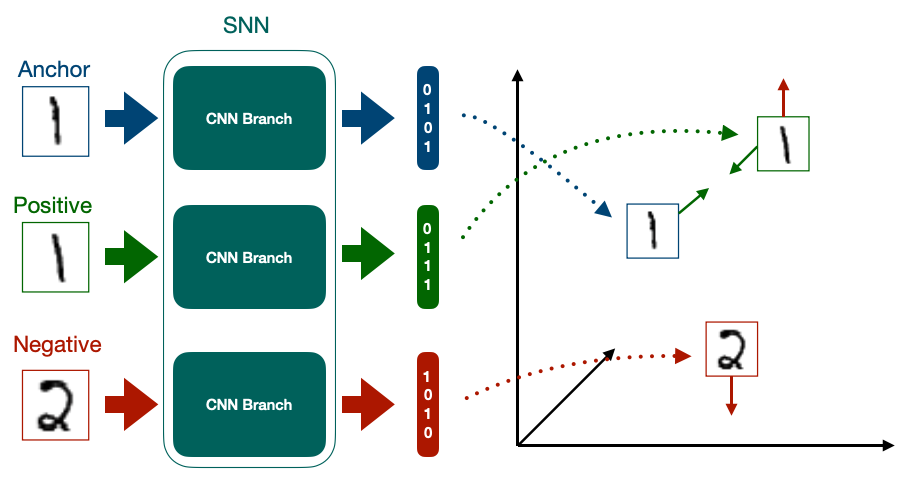

# Imports

In [25]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [27]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'
BATCH_SIZE = 32
LR = 0.001
EPOCHS =15

DEVICE = 'cuda'

In [28]:
df = pd.read_csv(CSV_FILE)

In [29]:
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [8]:
row = df.iloc[4]

In [9]:
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)


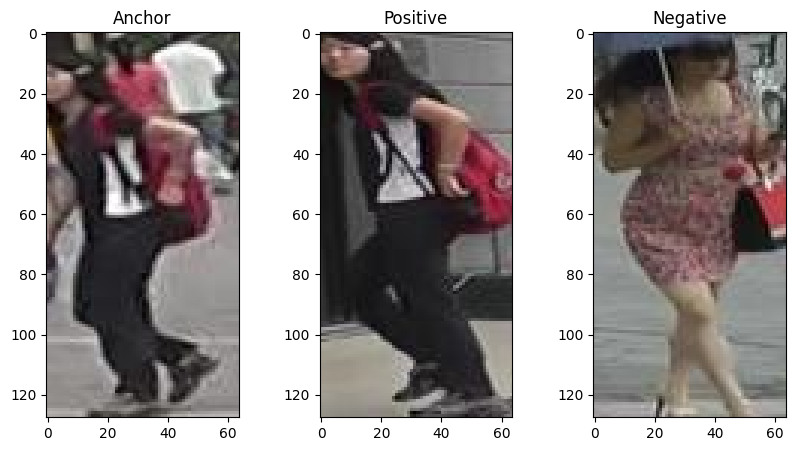

In [30]:
f, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)
ax2.set_title('Positive')
ax2.imshow(P_img)
ax3.set_title('Negative')
ax3.imshow(N_img)

In [11]:
train_df, valid_df = train_test_split(df,test_size=0.20,random_state = 42)

# Create APN Dataset

In [12]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0 ,1)/255.0
    P_img = torch.from_numpy(P_img).permute(2, 0 ,1)/255.0
    N_img = torch.from_numpy(N_img).permute(2, 0 ,1)/255.0

    return A_img, P_img, N_img

In [13]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f'size of trainset: {len(trainset)}')
print(f'size of validset: {len(validset)}')

size of trainset: 3200
size of validset: 800


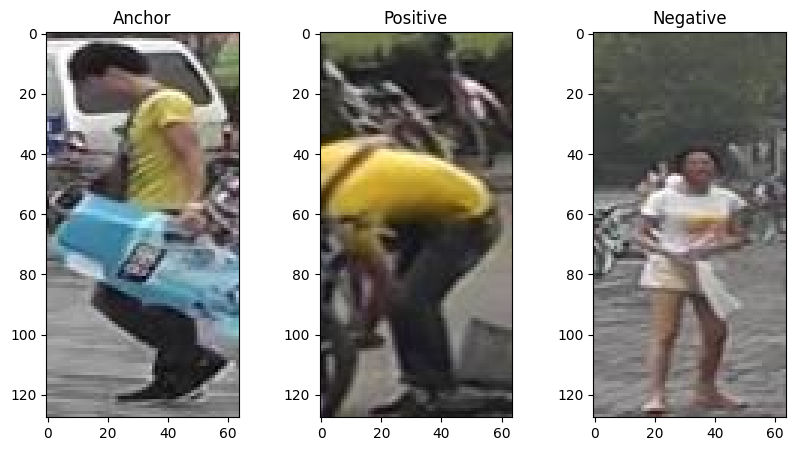

In [14]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [15]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [16]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [17]:
for A, P, N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [18]:
class APN_Model(nn.Module):
  def __init__(self, emb_size= 512):
    super(APN_Model,self).__init__()

    self.efficientnet = timm.create_model("efficientnet_b0", pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features,out_features=emb_size)

  def forward(self, image):

    embeddings = self.efficientnet(image)

    return embeddings

In [19]:
model = APN_Model()
model.to(DEVICE);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Create Train and Eval function

In [20]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [21]:
def valid_fn(model, dataloader, criterion):
  model.eval() #off Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()
    return total_loss/len(dataloader)


In [22]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

# Create Training Loop

In [32]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = valid_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
        print("WEIGHT SAVE SUCCESS")

    print(f'EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}')


100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 1 train_loss : 0.6477006766200065 valid_loss : 0.5503721284866333


100%|██████████| 25/25 [00:05<00:00,  4.23it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 2 train_loss : 0.3569196629524231 valid_loss : 0.36672772467136383


100%|██████████| 25/25 [00:03<00:00,  6.42it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 3 train_loss : 0.22398332491517067 valid_loss : 0.2773947763442993


100%|██████████| 25/25 [00:03<00:00,  6.40it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 4 train_loss : 0.12019963458180427 valid_loss : 0.20767688810825347


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 5 train_loss : 0.071490835621953 valid_loss : 0.19046963155269622


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 6 train_loss : 0.05397604465484619 valid_loss : 0.16968701422214508


100%|██████████| 25/25 [00:05<00:00,  4.34it/s]


EPOCHS : 7 train_loss : 0.04897115036845207 valid_loss : 0.17317389607429504


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


EPOCHS : 8 train_loss : 0.042748105973005296 valid_loss : 0.18323177337646485


100%|██████████| 25/25 [00:03<00:00,  7.04it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 9 train_loss : 0.053849696815013885 valid_loss : 0.1437487331032753


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


EPOCHS : 10 train_loss : 0.033674368858337404 valid_loss : 0.14900113105773927


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


EPOCHS : 11 train_loss : 0.04252155125141144 valid_loss : 0.148368176817894


100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 12 train_loss : 0.032270247340202333 valid_loss : 0.1318402683734894


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 13 train_loss : 0.028219054490327834 valid_loss : 0.10903008460998535


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


EPOCHS : 14 train_loss : 0.030149362683296203 valid_loss : 0.18671585917472838


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]

EPOCHS : 15 train_loss : 0.10006254389882088 valid_loss : 0.1902988338470459


# Get Anchor Embeddings

In [33]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []
  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) #(c,h,w)-> (bs,c,h,w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names,encodings],axis = 1)
  return df_enc

In [34]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model,df['Anchor'])

100%|██████████| 4000/4000 [00:55<00:00, 71.80it/s]


In [35]:
df_enc.to_csv('database.csv',index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.024266,0.811694,0.847154,-0.562794,-0.493589,-0.208242,0.068869,-0.915948,-0.450141,...,-0.478342,-0.184618,0.841368,-0.386103,-0.206931,-0.097068,0.832324,0.113672,-1.147770,0.197581
1,1420_c3s3_061978_03.jpg,0.064950,0.360968,0.686818,-0.093578,-0.643433,-0.798643,-0.643650,-1.640114,0.306801,...,-0.693615,-0.237229,0.985409,-0.051112,-0.807521,-0.126223,1.467229,-0.641440,-1.329144,0.241289
2,1420_c5s3_062565_05.jpg,-0.108855,0.561979,0.577907,-0.308726,-0.596564,-0.712400,-0.222736,-1.260335,-0.066781,...,-0.646891,-0.376057,0.940634,-0.211073,-0.470369,-0.199659,1.163142,-0.512777,-1.356680,0.271903
3,1420_c6s3_085592_04.jpg,-0.259096,0.101200,0.485063,0.139906,-0.017327,-0.112337,-0.062240,-0.843761,-0.196216,...,-0.220115,0.260159,0.639663,0.173179,-0.040808,-0.184812,0.627879,0.302775,-0.290281,-0.216796
4,0663_c5s3_085987_03.jpg,0.189488,-0.512355,-1.587273,0.554750,0.295771,0.078435,0.215343,0.447467,0.006826,...,0.852441,0.646823,-0.513788,0.403148,0.092728,-0.657721,-1.040804,0.393384,1.019912,-0.373508


# Inference

In [36]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr,(img_enc-anc_enc_arr).T))
  return dist

In [37]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR  + img_name


img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()



In [38]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [39]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc,anc_enc_arr[i:i+1,:])
  distance = np.append(distance,dist)

closest_idx = np.argsort(distance)

/usr/local/lib/python3.11/dist-packages/networkx/drawing/layout.py:728: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


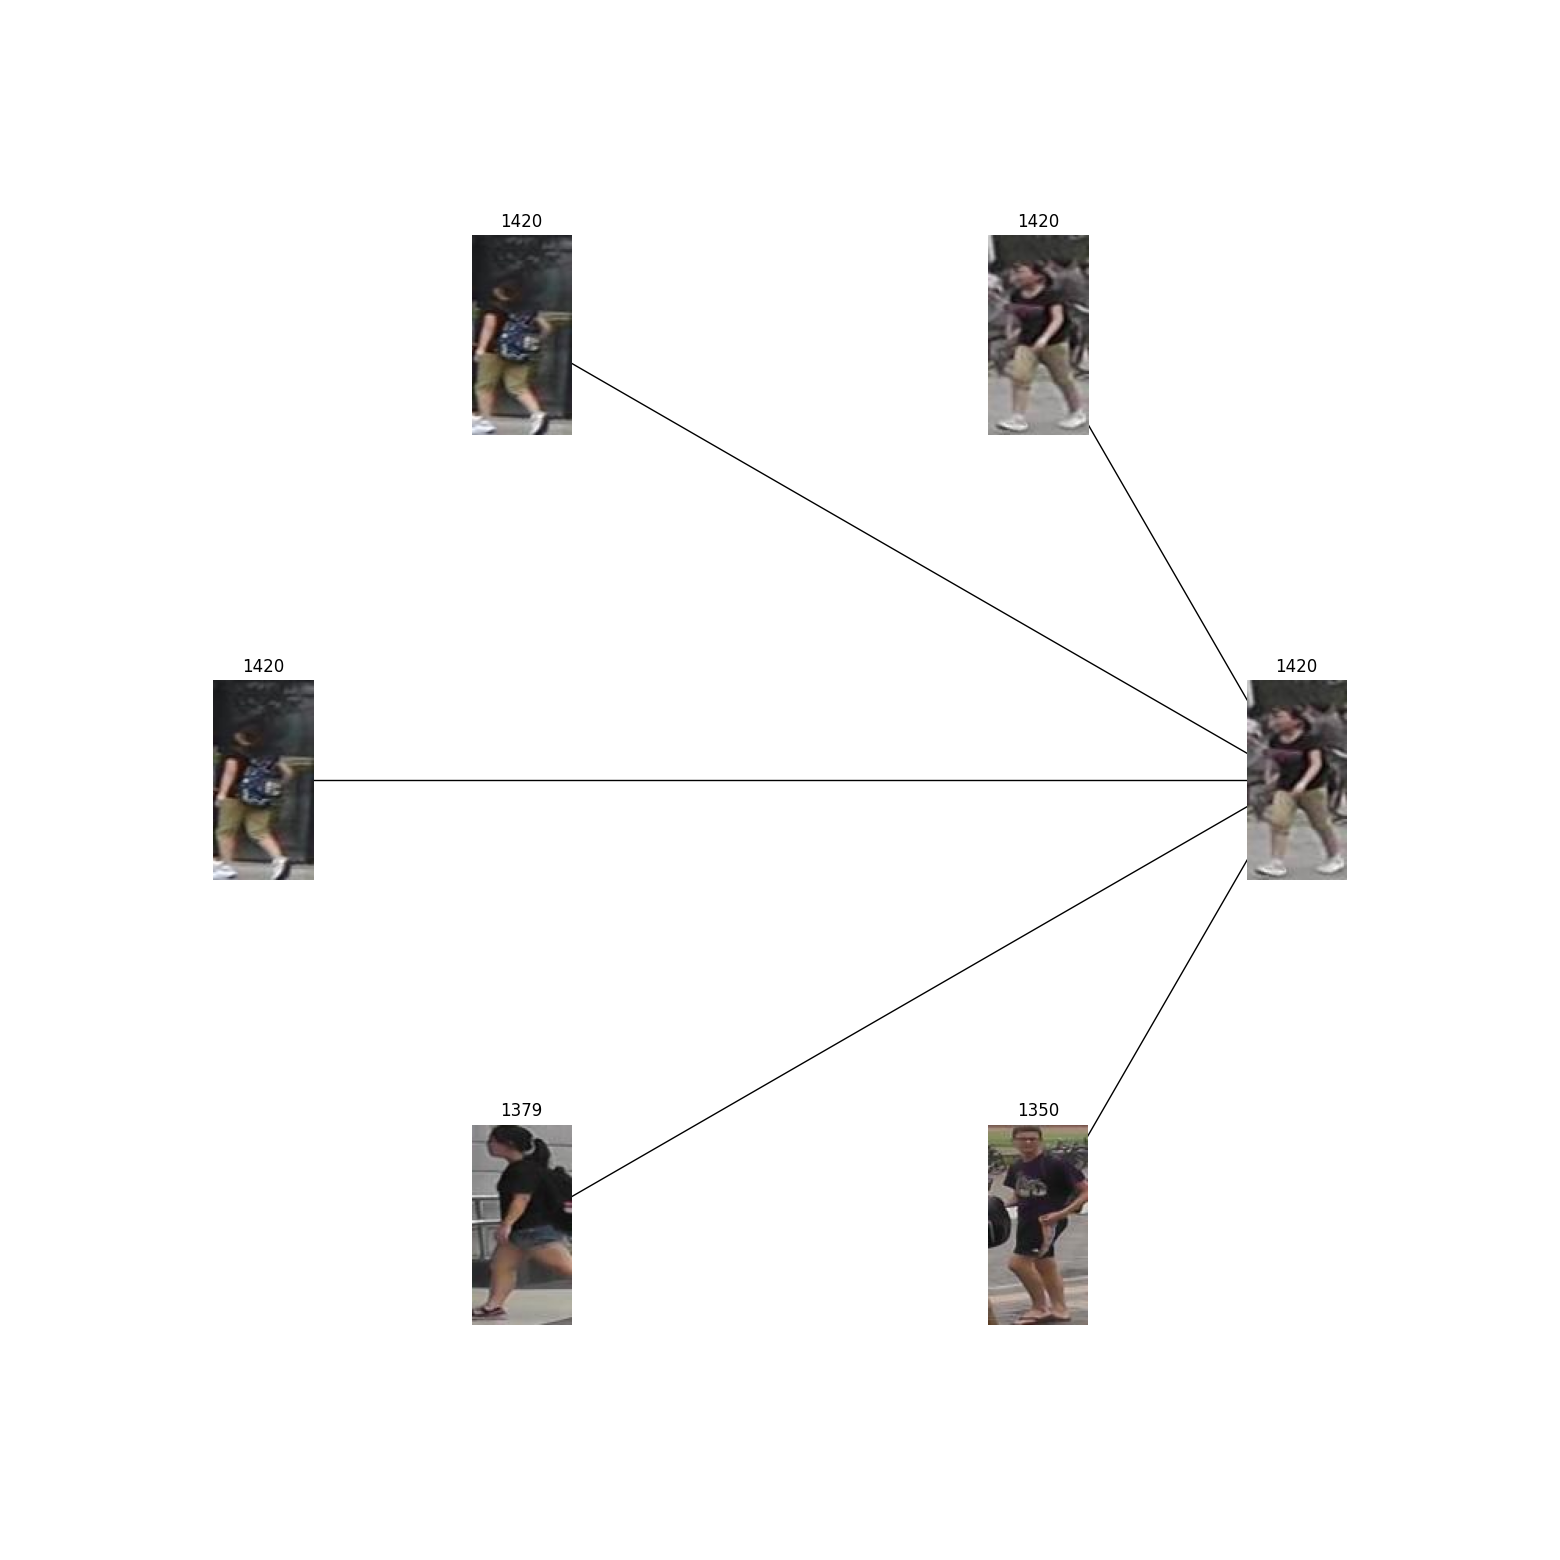

In [40]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);